# 서울시 편의점 위치와 매출의 관계 분석
## 02. 초기 시각화 (탐색용)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import platform

# OS에 따른 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # Mac
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

# PROJECT_DIR = r'C:/Users/Administrator/Desktop/자료모음/프로젝트_서울시_편의점_분석'
# OUTPUT_DIR = f'{PROJECT_DIR}/outputs'
OUTPUT_DIR = './outputs'
merged = pd.read_csv('./통합_데이터.csv', encoding='utf-8-sig')
merged['연도'] = (merged['기준_년분기_코드'] // 10).astype(int)
merged['분기'] = (merged['기준_년분기_코드'] % 10).astype(int)
merged['년분기'] = merged['연도'].astype(str) + 'Q' + merged['분기'].astype(str)

print(f'데이터 로드: {merged.shape}')

데이터 로드: (6097, 14)


### 시각화 1: 변수 분포 (히스토그램)

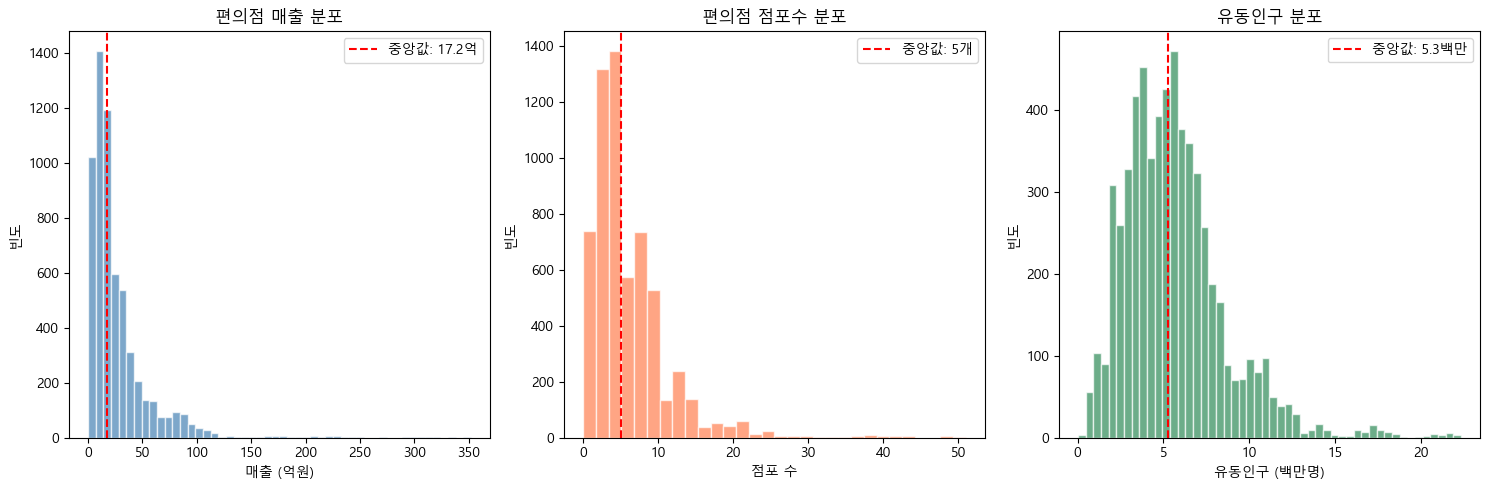

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(merged['당월_매출_금액']/1e8, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].axvline(merged['당월_매출_금액'].median()/1e8, color='red', linestyle='--', label=f'중앙값: {merged["당월_매출_금액"].median()/1e8:.1f}억')
axes[0].set_xlabel('매출 (억원)')
axes[0].set_ylabel('빈도')
axes[0].set_title('편의점 매출 분포')
axes[0].legend()

axes[1].hist(merged['점포_수'].dropna(), bins=30, color='coral', edgecolor='white', alpha=0.7)
axes[1].axvline(merged['점포_수'].median(), color='red', linestyle='--', label=f'중앙값: {merged["점포_수"].median():.0f}개')
axes[1].set_xlabel('점포 수')
axes[1].set_ylabel('빈도')
axes[1].set_title('편의점 점포수 분포')
axes[1].legend()

axes[2].hist(merged['총_유동인구_수'].dropna()/1e6, bins=50, color='seagreen', edgecolor='white', alpha=0.7)
axes[2].axvline(merged['총_유동인구_수'].median()/1e6, color='red', linestyle='--', label=f'중앙값: {merged["총_유동인구_수"].median()/1e6:.1f}백만')
axes[2].set_xlabel('유동인구 (백만명)')
axes[2].set_ylabel('빈도')
axes[2].set_title('유동인구 분포')
axes[2].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/01_변수분포.png', dpi=150, bbox_inches='tight')
plt.show()

### 시각화 2: 연도별 트렌드

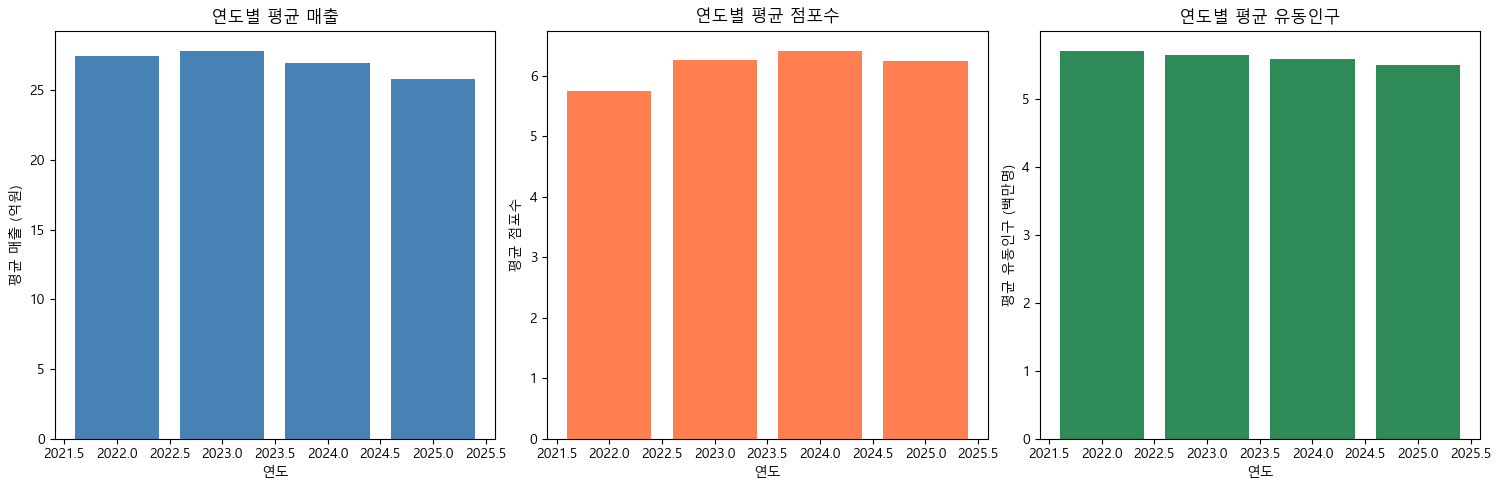

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

yearly = merged.groupby('연도').agg({
    '당월_매출_금액': 'mean',
    '점포_수': 'mean',
    '총_유동인구_수': 'mean'
}).reset_index()

axes[0].bar(yearly['연도'], yearly['당월_매출_금액']/1e8, color='steelblue')
axes[0].set_xlabel('연도')
axes[0].set_ylabel('평균 매출 (억원)')
axes[0].set_title('연도별 평균 매출')

axes[1].bar(yearly['연도'], yearly['점포_수'], color='coral')
axes[1].set_xlabel('연도')
axes[1].set_ylabel('평균 점포수')
axes[1].set_title('연도별 평균 점포수')

axes[2].bar(yearly['연도'], yearly['총_유동인구_수']/1e6, color='seagreen')
axes[2].set_xlabel('연도')
axes[2].set_ylabel('평균 유동인구 (백만명)')
axes[2].set_title('연도별 평균 유동인구')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/02_연도별_트렌드.png', dpi=150, bbox_inches='tight')
plt.show()

### 시각화 3: 상관관계 히트맵

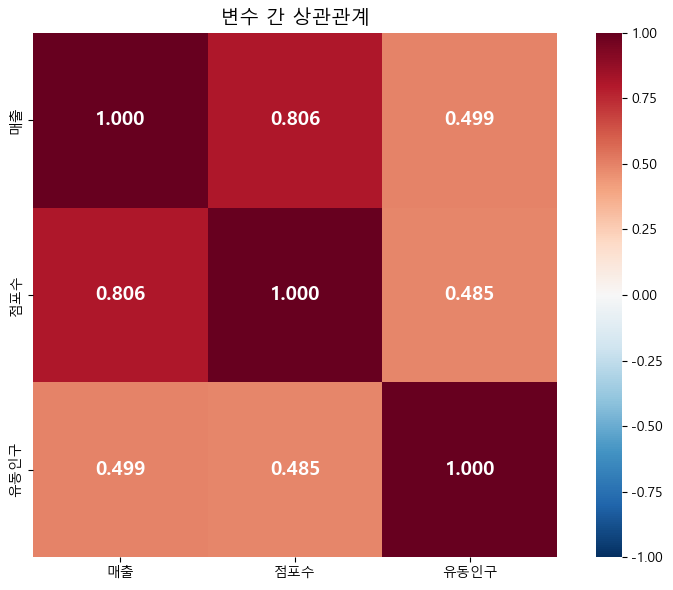

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

corr_cols = ['당월_매출_금액', '점포_수', '총_유동인구_수']
corr_matrix = merged[corr_cols].dropna().corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdBu_r', center=0,
            square=True, ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 14, 'weight': 'bold'})
ax.set_title('변수 간 상관관계', fontsize=14)
ax.set_xticklabels(['매출', '점포수', '유동인구'])
ax.set_yticklabels(['매출', '점포수', '유동인구'])

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/03_상관관계.png', dpi=150, bbox_inches='tight')
plt.show()

### 시각화 4: 상권유형별 매출 박스플롯

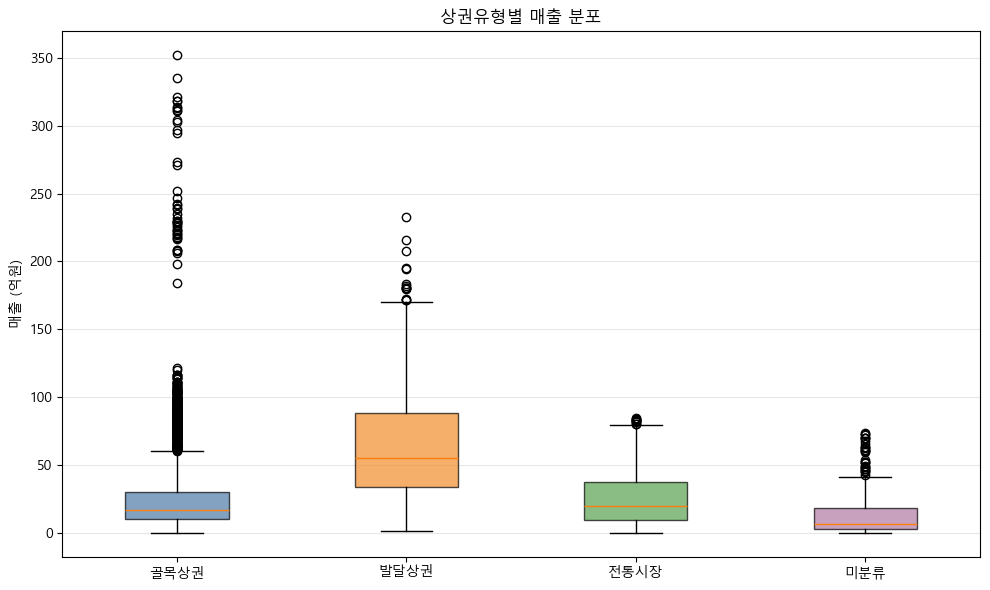

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

type_data = merged[merged['주요_상권유형'].notna()].copy()
order = ['골목상권', '발달상권', '전통시장', '미분류']
colors = ['#4E79A7', '#F28E2B', '#59A14F', '#B07AA1']  # 미분류: 보라색 계열

bp = ax.boxplot([type_data[type_data['주요_상권유형']==t]['당월_매출_금액']/1e8 for t in order if t in type_data['주요_상권유형'].values],
                labels=[t for t in order if t in type_data['주요_상권유형'].values],
                patch_artist=True)

for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('매출 (억원)')
ax.set_title('상권유형별 매출 분포')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/04_상권유형별_매출.png', dpi=150, bbox_inches='tight')
plt.show()

### 시각화 5: 산점도 (매출 vs 점포수/유동인구)

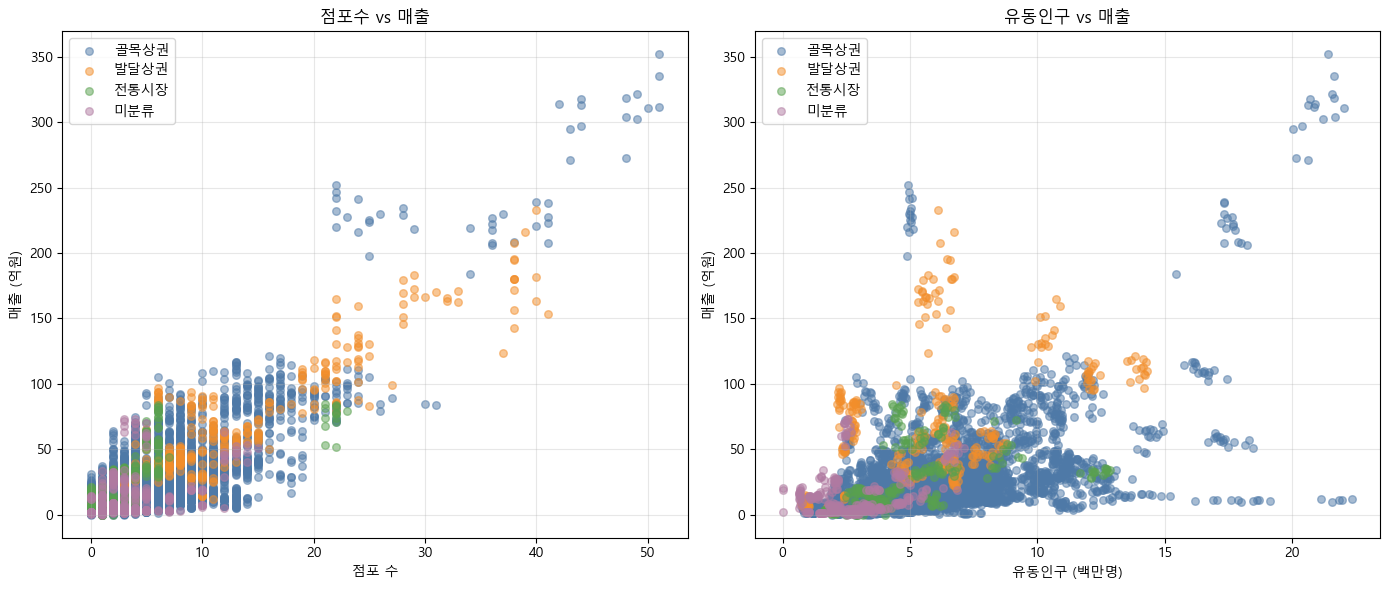

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter_data = merged.dropna(subset=['당월_매출_금액', '점포_수', '총_유동인구_수', '주요_상권유형'])
colors_map = {'골목상권': '#4E79A7', '발달상권': '#F28E2B', '전통시장': '#59A14F', '미분류': '#B07AA1'}

for t in colors_map.keys():
    subset = scatter_data[scatter_data['주요_상권유형'] == t]
    if len(subset) > 0:
        axes[0].scatter(subset['점포_수'], subset['당월_매출_금액']/1e8, 
                        c=colors_map[t], alpha=0.5, label=t, s=30)
        axes[1].scatter(subset['총_유동인구_수']/1e6, subset['당월_매출_금액']/1e8, 
                        c=colors_map[t], alpha=0.5, label=t, s=30)

axes[0].set_xlabel('점포 수')
axes[0].set_ylabel('매출 (억원)')
axes[0].set_title('점포수 vs 매출')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_xlabel('유동인구 (백만명)')
axes[1].set_ylabel('매출 (억원)')
axes[1].set_title('유동인구 vs 매출')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/05_산점도_상권유형별.png', dpi=150, bbox_inches='tight')
plt.show()

### 시각화 6: 분기별 매출 추이

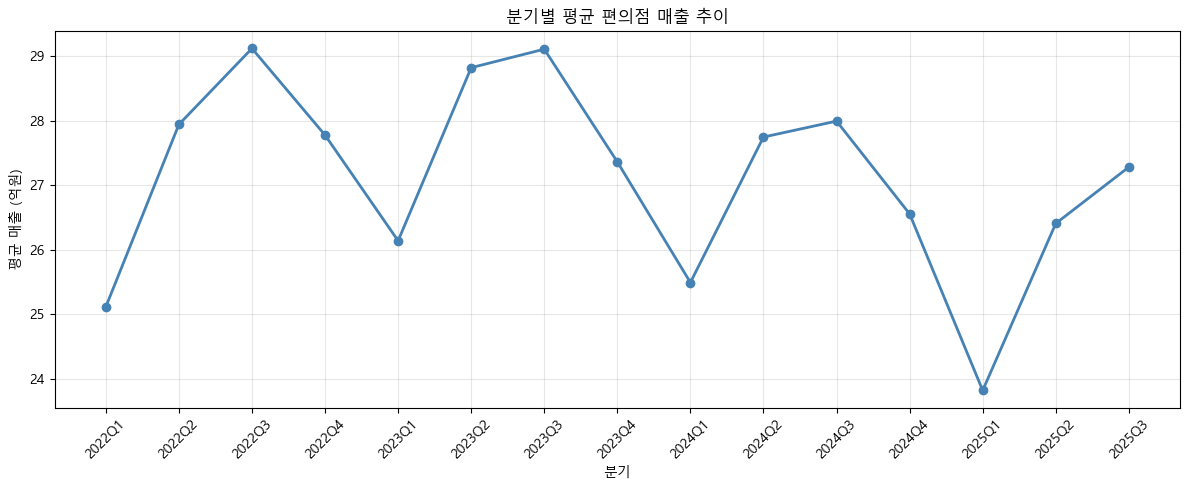

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

quarterly = merged.groupby('기준_년분기_코드').agg({'당월_매출_금액': 'mean'}).reset_index()
quarterly['년분기'] = quarterly['기준_년분기_코드'].apply(lambda x: f"{x//10}Q{x%10}")

ax.plot(quarterly['년분기'], quarterly['당월_매출_금액']/1e8, 
        marker='o', linewidth=2, markersize=6, color='steelblue')
ax.set_xlabel('분기')
ax.set_ylabel('평균 매출 (억원)')
ax.set_title('분기별 평균 편의점 매출 추이')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/06_분기별_매출추이.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 시각화 결과 요약

1. **변수 분포**: 매출과 유동인구 모두 오른쪽 꼬리가 긴 분포 (양의 왜도)
2. **연도별 트렌드**: 매출은 2023년 정점 후 하락, 점포수는 증가 추세
3. **상관관계**: 매출-점포수(0.81 강한 양의 상관), 매출-유동인구(0.49 중간 상관)
4. **상권유형**: 발달상권이 가장 높은 매출, 골목상권이 가장 많은 비중
5. **분기별 추이**: 계절적 패턴 존재 가능성